In [55]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import scipy
from scipy import interpolate
from scipy import integrate
N = 10000 # number of iterator steps
H_to_K = 1/0.000003166808534191

## Q's
#### 1.) Where do I pick wave number k in the delta formula, assume k(rmax) since that is the place where the u(r) = sin(kr + delta) approx holds
#### 2.) What does left wall of the the LJ pot look like, an infinite wall, finite but large wall, something else? Do BC's change? Do I set u(r) = 0 for all r < rmin st V(rmin) > 0. Does u(r) look like decaying expoential at boundary (how it is now) or look 0 at rmin
#### 3.) What is an appropriate energy range to look at, check this

# Goals
## 1.) Converge delta wrt r1, r1 being minimum positive r to start at
## 2.) Coverge delta wrt r2, r2 being max value of r to iterate out to
## 3.) Coverge delta wrt dr, step size, (20 setps per deBroglie wavelength)

# #1 Coverge Delta wrt r1

# $V(r) = \frac{C_{12}}{r^{12}} - \frac{C_{6}}{r^{6}}$
## $C_{12} = 3.05\times10^{8} E_{h}a_{0}, C_{6} = 4710 E_{h}a_{0}$

 dr = 0.005600560056005399
-5741.956634039557


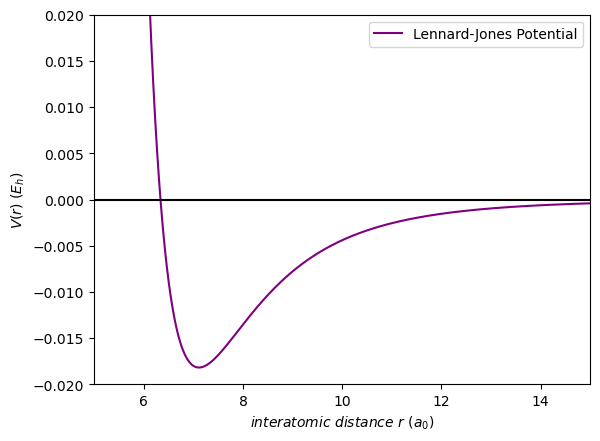

In [57]:
tol = 1e-4
#r1 = np.linspace(1e-2, 6, 500) #rmin in ao
r = np.linspace(4,60, N) # range of r values to iterate over, ~0 -> 80 Bohr radii
dr = r[1] - r[0] # spacing dr
print(f' dr = {dr}')
psi = np.zeros(N)  # Initializing psi(r) as array of zeros

C12 = 3.05e8 #C12 coefficient in Eh*ao
C6 = 4710 #C6 coefficient in Eh*ao
Vr = (C12/(r**12)) - (C6/(r**6))
Eo = 1e5*3.166808534191e-12 # inital particle energy, 1uK in Hartrees
me = 9.1093837e-28 # electron mass in grams
mrb_g = 1.4192261e-22 # rubidium mass in grams
mrb = mrb_g/me # rubidium mass in au
mu = (mrb**2)/(2*mrb) # reduced mass of rubidium
hbar = 1.0546e-27 # reduced Planck constant in cgs
e = 4.8032e-10 # electron charge in cgs
ao = (hbar**2)/(me*e**2) # Bohr radius in cgs


#print(f' mu = {mu}')
plt.plot(r, Vr, label = 'Lennard-Jones Potential', color = 'purple')
plt.hlines(0,0, max(r), color = 'black')
#plt.hlines(Eo,0, max(r), color = 'green')
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{0})$')
plt.ylabel('$V(r)$ $(E_{h})$')
plt.ylim(-0.02, 0.02)
plt.xlim(5,15)
plt.legend()


print(min(Vr)*H_to_K)

## $\psi(r_{n+1}) = \frac{2(1-\frac{5}{12}(dr)^2k^2_{n})\psi_{n} - (1 + \frac{1}{12}(dr)^2k^2_{n-1})\psi_{n-1}}{1 + \frac{1}{12}(dr)^2k^2_{n+1}}    $

In [37]:
def wavefunction(Energy, M, r_range): # Numerov method function to find psi(r)
    VLJ = (C12/(r_range**12)) - (C6/(r_range**6))
    psi[0] = 0 # impose boundary condition psi(0) = 0
    psi[1] = 1e-5 # let psi(dr) = 1e-5
    #print(f' psi[1] = {psi[1]}')
    ksq = 2*mu*(Energy - VLJ) # wave number squared for the energy

    for i in range(2,M):  # Numerov Algorithm, range is 2 -> N since psi(0), psi(1) already set
        #if i < 50:
            #print(ksq)
            #print(f' first term in numerator is {(2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1])}')
            #print(f' numerator is {((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))}')
            #print(f' denominator is {(1 + (1/12)*(dr**2)*ksq[i])}')
            #print(psi[i])
        psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
    Psi_f = psi/max(psi)
    

            
    return Psi_f



In [38]:
for i in range(int(len(Vr))):
    if Vr[i] == min(abs(Vr[400:450])):
        print(f' Vr at r1max = {Vr[i]}')
        print(f' r when V(r) = 0 is {r[i]}')
        r1max = r[i]

print(min(abs(Vr)))

print(Vr[41])

1.0095150597546929e-07
0.002820773542644109


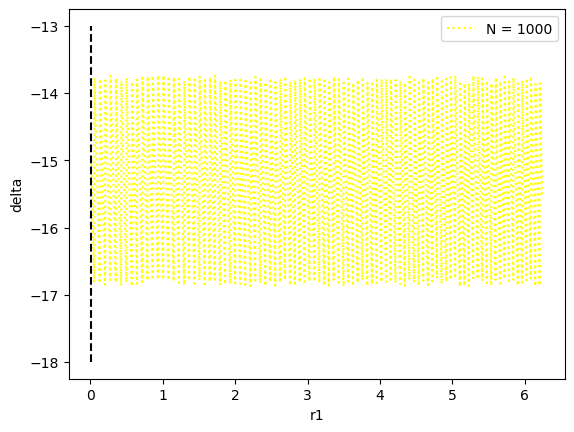

In [39]:
r1max = r[41]
r1 = np.linspace(1e-2,r1max - dr,2500) #rmin in ao
delta_r1 = []
print(f' dr = {dr}ao')

for i in range(len(r1)):
    r1_range = np.linspace(r1[i],60, N) # range of r1 values to iterate over, r1 -> 60 Bohr radii
    VLJ_r1 = (C12/(r1_range**12)) - (C6/(r1_range**6))
    ko1 = 2*mu*(Eo - VLJ_r1)

    Psi_r1 = wavefunction(Eo, N, r1_range)
    psi_r1prime = np.gradient(Psi_r1, r1_range)
    delt1 = np.arctan((np.sqrt(ko1[-1])*Psi_r1[-1])/(psi_r1prime[-1])) - np.sqrt(ko1[-1])*r1_range[-1]
    delta_r1.append(delt1)
    #if i == 1:
     #   plt.plot(r1_test, Psi_r1, color = 'red', label = f'r1 = {r1[i]}')
    #if i == int(3*len(r1)/4):
     #   plt.plot(r1_test, Psi_r1, color = 'blue', label = f'r1 = {r1[i]}')
        

#print(len(delta_r1))

plt.plot(r1, delta_r1, color = 'yellow', linestyle = 'dotted', label = 'N = 1000')
plt.vlines(r1[0], -18,-13, color = 'black', linestyle = 'dashed')
plt.xlabel('r1')
plt.ylabel('delta')
plt.legend()
plt.savefig('N_1000_r1_in_1e_neg2_r1max_-_dr.png')

#psi_1prime = np.gradient(Psi_1, r)
#plt.plot(r, Psi_1, label = f' $\\psi(r)$', color = 'red') 
#plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
#plt.ylabel('$\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')
#plt.legend()

#plt.xlim(0,15)

#print(delta_r1[0:100])

 dr = 0.005600560056005399ao
 Vr at r1max = 0.00010420934115275282
 r when V(r) = 0 is 6.335433543354336


C:\Users\nienn\AppData\Local\Temp\ipykernel_22216\1866253648.py:15: RuntimeWarning: overflow encountered in scalar multiply
  psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
C:\Users\nienn\AppData\Local\Temp\ipykernel_22216\1866253648.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
C:\Users\nienn\AppData\Local\Temp\ipykernel_22216\1866253648.py:16: RuntimeWarning: invalid value encountered in divide
  Psi_f = psi/max(psi)
C:\Users\nienn\AppData\Local\Temp\ipykernel_22216\1866253648.py:15: RuntimeWarning: overflow encountered in scalar divide
  psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
C:\Users\nienn\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1250: RuntimeWarning: invalid v

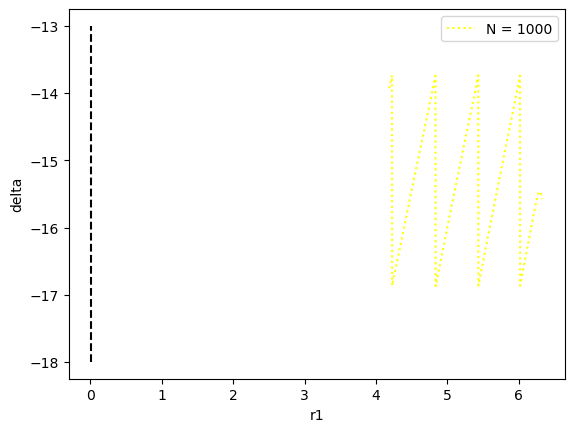

In [59]:
Q = 10000
print(f' dr = {dr}ao')

for i in range(int(len(Vr))):
    if Vr[i] == min(abs(Vr[400:450])):
        print(f' Vr at r1max = {Vr[i]}')
        print(f' r when V(r) = 0 is {r[i]}')
        r1max = r[i]

r1 = np.linspace(1e-2,r1max - dr,2500) #rmin in ao
delta_r1 = []

for i in range(len(r1)):
    r1_range = np.linspace(r1[i],60, Q) # range of r1 values to iterate over, r1 -> 60 Bohr radii
    #print(f' len(r1) = {len(r1_range)}')
    VLJ_r1 = (C12/(r1_range**12)) - (C6/(r1_range**6))
    ko1 = 2*mu*(Eo - VLJ_r1)
  #  print(f' len(ksq) = {len(ko1)}')

    Psi_r1 = wavefunction(Eo, Q, r1_range)
    psi_r1prime = np.gradient(Psi_r1, r1_range)
    delt1 = np.arctan((np.sqrt(ko1[-1])*Psi_r1[-1])/(psi_r1prime[-1])) - np.sqrt(ko1[-1])*r1_range[-1]
    delta_r1.append(delt1)
    #if i == 1:
     #   plt.plot(r1_test, Psi_r1, color = 'red', label = f'r1 = {r1[i]}')
    #if i == int(3*len(r1)/4):
     #   plt.plot(r1_test, Psi_r1, color = 'blue', label = f'r1 = {r1[i]}')
        

#print(len(delta_r1))

plt.plot(r1, delta_r1, color = 'yellow', linestyle = 'dotted', label = 'N = 10000')
plt.vlines(r1[0], -18,-13, color = 'black', linestyle = 'dashed')
plt.xlabel('r1')
plt.ylabel('delta')
plt.legend()
plt.savefig('N_1000_r1_in_1e_neg2_r1max_-_dr.png')

#psi_1prime = np.gradient(Psi_1, r)
#plt.plot(r, Psi_1, label = f' $\\psi(r)$', color = 'red') 
#plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
#plt.ylabel('$\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')
#plt.legend()

#plt.xlim(0,15)

#print(delta_r1[0:100])

In [23]:
plt.show('N_1000_r1_in_1e_neg2_r1max_-_dr.png')

# For now, r1 = 3.81ao

### $\psi(r) = sin(kr + \delta), \frac{d\psi}{dr} = kcos(kr + \delta)$
### $\frac{\psi}{\frac{d\psi}{dr}} = \frac{1}{k}tan(kr + \delta)$
### $tan^{-1}(\frac{k\psi_{n}}{\frac{d\psi_{n}}{dr}}) = kr + \delta$
### $\delta = tan^{-1}(\frac{k\psi_{n}}{\frac{d\psi_{n}}{dr}}) - kr $

In [ ]:
#ko = np.sqrt(2*mu*(Eo - Vr))
#delt = np.arctan((np.sqrt(ko)*Psi_1)/(psi_1prime)) - np.sqrt(ko)*r
#plt.plot(r, delt, color = 'yellow', label = '$\\delta$')
#plt.ylabel('$\\delta$')
#plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
#plt.legend()

# #2 Coverge Delta wrt r2

In [ ]:
r2 = np.linspace(60,120,500) #rmin in ao
delta_r2 = []

for i in range(len(r2)):
    r2_range = np.linspace(3.85,r2[i], N) # range of r1 values to iterate over, r1 -> 60 Bohr radii
    VLJ_r2 = (C12/(r2_range**12)) - (C6/(r2_range**6))
   # print(VLJ_r2[-1])
    ko2 = 2*mu*(Eo - VLJ_r2)

    Psi_r2 = wavefunction(Eo, N, r2_range)
    psi_r2prime = np.gradient(Psi_r1, r2_range)
    delt2 = np.arctan((np.sqrt(ko2[-1])*Psi_r2[-1])/(psi_r2prime[-1])) - np.sqrt(ko2[-1])*r2_range[-1]
    delta_r2.append(delt2)
    if i == 1:
    #    plt.plot(r2_range, Psi_r2, color = 'red', label = f'r2 = {r2[i]}')
        print((VLJ_r2[-1],VLJ_r2[-1]*H_to_K))
   # if i == int(3*len(r2)/4):
   #     plt.plot(r2_range, Psi_r2, color = 'blue', label = f'r2 = {r2[i]}')
   # if i == int(len(r2) - 1):
   #     plt.plot(r2_range, Psi_r2, color = 'green', label = f'r2 = {r2[i]}')
        

#print(len(delta_r1))

plt.plot(r2, delta_r2, color = 'yellow', linestyle = 'dotted', label = 'delta')
#plt.vlines(r2[-1], -18,-13, color = 'black', linestyle = 'dashed')
plt.xlabel('r2')
plt.ylabel('delta')
plt.legend()

# #3 Coverge Delta wrt dr

In [ ]:
tol = 1e-4
r1_dr = 1 #rmin in ao
r = np.linspace(r1_dr,40, N) # range of r values to iterate over, ~0 -> 80 Bohr radii
#dr = r[1] - r[0] # spacing dr
#print(f' dr = {dr}')
psi = np.zeros(N)  # Initializing psi(r) as array of zeros

ko = np.sqrt(2*mu*(Eo - Vr))
C12 = 3.05e8 #C12 coefficient in Eh*ao
C6 = 4710 #C6 coefficient in Eh*ao
Vr = (C12/(r**12)) - (C6/(r**6))
Eo = 1e5*3.166808534191e-12 # inital particle energy, 1uK in Hartrees
me = 9.1093837e-28 # electron mass in grams
mrb_g = 1.4192261e-22 # rubidium mass in grams
mrb = mrb_g/me # rubidium mass in au
mu = (mrb**2)/(2*mrb) # reduced mass of rubidium
hbar = 1.0546e-27 # reduced Planck constant in cgs
e = 4.8032e-10 # electron charge in cgs
ao = (hbar**2)/(me*e**2) # Bohr radius in cgs


#print(f' mu = {mu}')
plt.plot(r, Vr, label = 'Lennard-Jones Potential', color = 'purple')
plt.hlines(0,0, max(r), color = 'black')
#plt.hlines(Eo,0, max(r), color = 'green')
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{0})$')
plt.ylabel('$V(r)$ $(E_{h})$')
plt.ylim(-0.02, 0.02)
plt.xlim(5,15)
plt.legend()



### $k(r) = \sqrt{2\mu(E - V(r))}$
### $\lambda_{min} = \frac{2\pi}{k_{max}} = \frac{2\pi}{\sqrt{2\mu(E - V_{min})}}$
### $dr \leq \frac{\lambda_{min}}{20}$

In [ ]:
lambda_min = (2*np.pi)/(np.sqrt(2*mu*(Eo - min(Vr))))
print(f' lambda min = {lambda_min}ao')
print(f' dr = {lambda_min/20}ao')

In [ ]:
def wavefunction(Energy, length, r_range, dr): # function to find psi(r)
    VLJ = (C12/(r_range**12)) - (C6/(r_range**6))
    psi[0] = 0 # impose boundary condition psi(0) = 0
    psi[1] = dr # let psi(dr) = the spacing length
    #print(f' psi[1] = {psi[1]}')
    ksq = 2*mu*(Energy - VLJ) # wave number squared for the energy

    for i in range(2,length):  # Numerov Algorithm, range is 2 -> N since psi(0), psi(1) already set
        #if i < 100:
         #   print(f' first term in numerator is {(2*(1 - (5/12)*(dr**2)*k[i-1])*psi[i-1])}')
        psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])

M = np.arange(6500, 10500, 50)
print(len(M))
dr_list = []

for i in range(len(M)):
    dr_r_ranges = np.linspace(3.81, 120, M[i]) 
    if i < int(len(M)/2):
        print(len(dr_r_ranges))
    #dr_range.append(dr)
    spacing = dr_r_ranges[1] - dr_r_ranges[0]
    dr_list.append(spacing)
    
    Psi_dr = wavefunction(Eo, M[i], dr_r_ranges, spacing)
    print(Psi_dr)
    if i == 1:
        plt.plot(dr_r_ranges, Psi_dr, color = 'red')
    print(f' len(Psi) = {len(Psi_dr)}')
    print(f' len(dr_r_range) = {len(dr_r_ranges)}')
    psi_drprime = np.gradient(Psi_dr, dr_r_ranges)
    delt = np.arctan((np.sqrt(ko)*Psi_dr)/(psi_drprime)) - np.sqrt(ko)*dr_r_ranges
    delta_dr.append(delt[-1])
plt.plot(dr_list, delta_dr, color = 'yellow')

In [ ]:

for i in range(len(M)):
    dr_r_ranges = np.linspace(3.81, 120, M[i]) 
    if i < int(len(M)/2):
        print(len(dr_r_ranges))
    #dr_range.append(dr)
    spacing = dr_r_ranges[1] - dr_r_ranges[0]
    dr_list.append(spacing)


            
        return psi 

    VLJ_dr = (C12/(dr_r_ranges**12)) - (C6/(dr_r_ranges**6))
    ko = 2*mu*(Eo - VLJ_dr)
    for i in range(len(M)):


        #if i == 1:
            #plt.plot(r1_test, Psi_r1, color = 'red', label = 'r1 = 0')
        #if i == int(3*N/4):
            #plt.plot(r1_test, Psi_r1, color = 'blue', label = 'r1 = 7.5')


In [ ]:
x = np.arange(1,7501, 1)
y = 1/(x**2)
print(min(y))